In [255]:
import numpy as np 
from On_FV_MC_agent_esoft2 import OnPolicy_esoft_FirstVisit_MC_Agent
from SARSA_agent import SARSA_Agent
from Two_step_Exp_SARSA_agent import Two_step_Exp_SARSA_Agent
from Double_Q_Learning_agent import Double_Q_Learning_Agent
from nStep_tree_backup_agent import nStep_tree_backup_Agent
from Off_MC_agent import OffPolicy_MC_Agent
from tqdm import tqdm 
import matplotlib.pyplot as plt
import  random 


In [256]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv2(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,73,74]
      no_down = lambda s: s in [23,24,54]
      no_left = lambda s: s in [44,35,54,65]
      no_right = lambda s: s in [32,42,52,62]

      #Barries in the path
      pit = lambda s: s in [13,72,41]
      wall = lambda s: s in [43,33,53,34,64,63]

      #Rewards of each state
      reward = 50.0 if is_done(s) else -1.0
      reward = -15.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1, s, reward, True)]
        P[s][RIGHT] = [(1, s, reward, True)]
        P[s][DOWN] = [(1, s, reward, True)]
        P[s][LEFT] = [(1, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1, s, -5.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1, s, -5.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1, s, -5.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1, s, -5.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv2, self).__init__(nS, nA, P, isd)


      
  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,72,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,72,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,64,63]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()




In [257]:
env =  GridworldEnv2()
env.reset()
env._render()

for _ in range(4):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # Take a random action
    print(info)
    print('action:',action)
    env._render()
env.close()


       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
{'prob': 1}
action: 0
       .    .    .    .    .    .    .    .    .  
  .    .    .         .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .         .    █    웃   .    .    .    .    .  
  .    .    .    █    .    .    .    .    .    .  
  .    .    .    █    █    .    .    .    .    .  
  .    .         .    .    .    .    .    .    .  
  .    .    .    .    .    .    .    .    .    .  
  .    .   

In [258]:
env =  GridworldEnv()
env.P[1]

{0: [(1, 1, -1.0, False)],
 1: [(1, 2, -1.0, False)],
 2: [(1, 11, -1.0, False)],
 3: [(1, 0, -1.0, True)]}

In [259]:
def Generate_episode(agent,init_state):
    episode = []
    rewards = []
    n_done = 0
    agent.set_current_state(init_state)
    while n_done != 2: 
        s = agent.get_current_state()
        state, reward, done, info , action = agent.take_action()
        #print(s,state, reward, done, info , action)
        episode.append((s,action))
        rewards.append(reward)
        n_done += int(done)
    #print(rewards[-1])
    return episode,rewards 

# On Policy MC

In [260]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

gamma = 0.9
episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_on_MC = []
RewPerEps_on_MC = []

agent = OnPolicy_esoft_FirstVisit_MC_Agent('1',env,states,actions,epsilon = 0.5,dec_eps=[5,50,1]) #epsilon decay???
for e in range(episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    env.reset()

    episode, rewards = Generate_episode(agent, init_state = 44 )
    print("The number of steps in episode is : {}".format(len(episode)-1))
    G = 0
    for t in range(len(episode)-1,-1,-1):
        G = gamma * G + rewards[t] 
        if episode[t] not in episode[:t-1]:
            agent.update(G,state = episode[t][0], action = episode[t][1])

    agent.decay_epsilon()
    Rewards.append(sum(rewards))
    if e >= 100 : Win_Rew_on_MC.append((sum(rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_on_MC.append(sum(rewards))
    RewPerEps_on_MC.append(sum(rewards)/(len(episode)-1))
    print("The sum of Rewards is : {} ".format(sum(rewards)),"\n" )
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

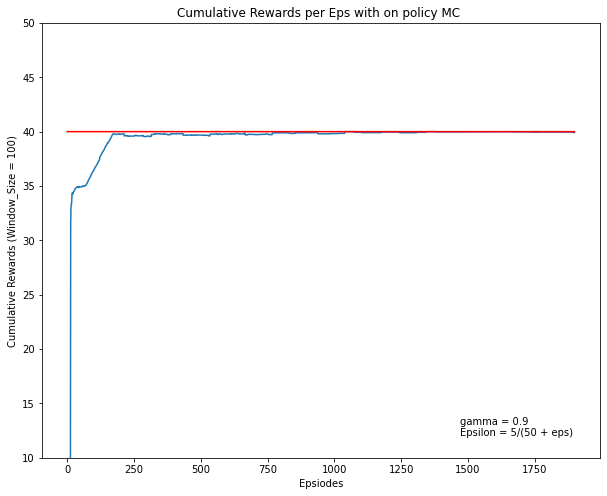

In [261]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_on_MC[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with on policy MC ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 5/(50 + eps)", transform=ax.transAxes)
plt.show()

# Off Policy MC 

In [262]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

gamma = 0.9
episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_off_MC = []

agent = OffPolicy_MC_Agent('1',env,states,actions,epsilon = 0.5,dec_eps=[8,80,1]) #epsilon decay???
for e in range(episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    env.reset()
    episode, rewards = Generate_episode(agent, init_state = 44 )
    print("The number of steps in episode is : {}".format(len(episode)-1))
    G = 0
    W = 1
    for t in range(len(episode)-1,-1,-1):
        G = gamma * G + rewards[t] 
        pi_s_t , b_t = agent.update(G,W,state = episode[t][0], action = episode[t][1])
        if episode[t][1] != pi_s_t:
            break
        W = W / b_t

    agent.decay_epsilon()
    Rewards.append(sum(rewards))
    if e >= 100 : Win_Rew_off_MC.append((sum(rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_off_MC.append(sum(rewards))
    print("The sum of Rewards is : {} ".format(sum(rewards)),"\n" )
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

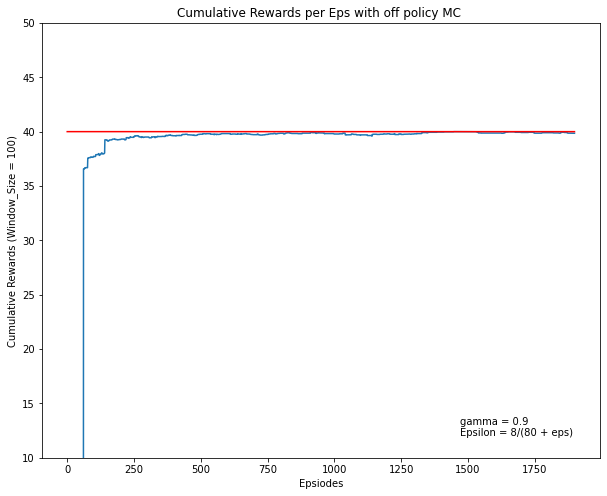

In [263]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_off_MC[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with off policy MC ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 8/(80 + eps)", transform=ax.transAxes)
plt.show()

In [264]:
env.reset()

episode = []
rewards = []
n_done = 0

agent.set_current_state(44)
while n_done != 2: 
    s = agent.get_current_state()
    state, reward, done, info , action = agent.choose_action()
    print(s,state, reward, done, action)
    episode.append((s,action))
    rewards.append(reward)
    n_done += int(done)
print(len(episode)-1)

44 45 -1.0 False 1
45 35 -1.0 False 0
35 25 -1.0 False 0
25 24 -1.0 False 3
24 23 -1.0 False 3
23 22 -1.0 False 3
22 21 -1.0 False 3
21 20 -1.0 False 3
20 10 -1.0 False 0
10 0 -1.0 True 0
0 0 50.0 True 0
10


# SARSA

In [265]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_SARSA = []
agent=SARSA_Agent('1',env,states,actions,epsilon = 0.5,learning_rate=0.2,gamma = 0.9,dec_eps = [1,100,1],dec_alph=[100,100,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    rewards = []
    episode = []
    env.reset()
    agent.set_current_state(44)
    S = agent.get_current_state()
    A = agent.choose_action()
    while n_done != 2: 
        S_prime, R, done, info = agent.take_action(A)
        A_prime = agent.choose_action()
        agent.update(R,S,A,S_prime,A_prime)
        n_done += int(done)
        episode.append((S,A))
        rewards.append(R)
        S = S_prime
        A = A_prime

    Rewards.append(sum(rewards))
    if e >= 100 : 
        Win_Rew_SARSA.append((sum(rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_SARSA.append(sum(rewards))
    print("The number of steps in episode is : {}".format(len(episode)-1))
    print("The sum of Rewards is : {} ".format(sum(rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

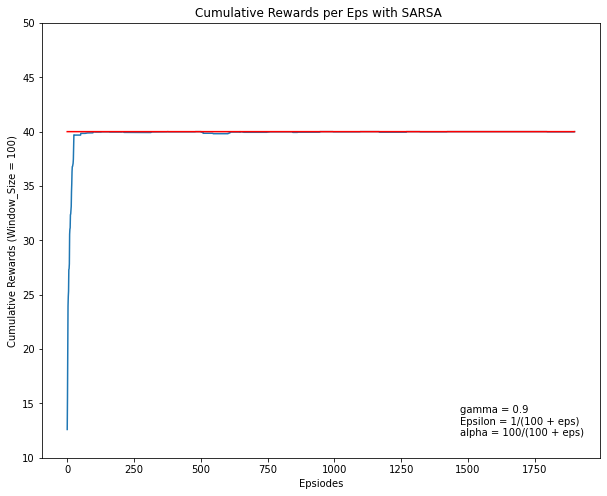

In [287]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_SARSA[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with SARSA ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 1/(100 + eps) \nalpha = 100/(100 + eps)", transform=ax.transAxes)
plt.show()

# Double Q-Learning

In [267]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_Double_Q = []
agent=Double_Q_Learning_Agent('1',env,states,actions,epsilon = 0.5,learning_rate=0.2,gamma= 0.9,dec_eps=[1,100,1],dec_alph=[100,500,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    rewards = []
    episode = []
    env.reset()
    agent.set_current_state(44)
    S = agent.get_current_state()
    while n_done != 2: 
        A = agent.choose_action()
        S_prime, R, done, info = agent.take_action(A)
        agent.update(R,S,A,S_prime)
        n_done += int(done)
        episode.append((S,A))
        rewards.append(R)
        S = S_prime

    Rewards.append(sum(rewards))
    if e >= 100 : Win_Rew_Double_Q.append((sum(rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_Double_Q.append(sum(rewards))
    print("The number of steps in episode is : {}".format(len(episode)-1))
    print("The sum of Rewards is : {} ".format(sum(rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

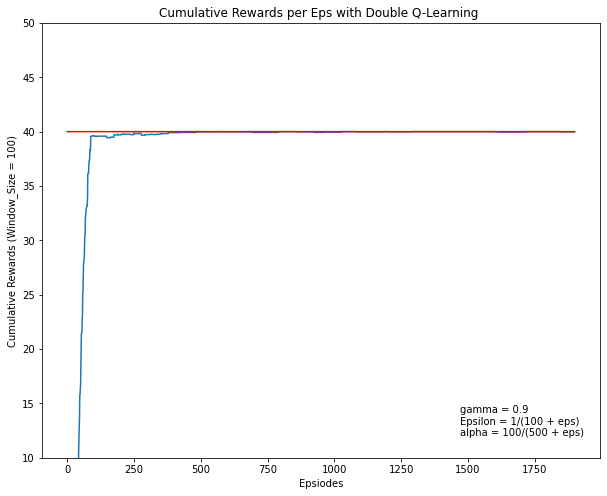

In [268]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_Double_Q[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with Double Q-Learning ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 1/(100 + eps) \nalpha = 100/(500 + eps)", transform=ax.transAxes)
plt.show()

In [269]:
env.reset()

episode = []
rewards = []
n_done = 0

agent.set_current_state(44)
while n_done != 2: 
    s = agent.get_current_state()
    action = agent.choose_action()
    state, reward, done, info = agent.take_action(action)
    print(s,state, reward, done, action)
    episode.append((s,action))
    rewards.append(reward)
    n_done += int(done)
print(len(episode)-1)

44 45 -1.0 False 1
45 35 -1.0 False 0
35 25 -1.0 False 0
25 24 -1.0 False 3
24 23 -1.0 False 3
23 22 -1.0 False 3
22 12 -1.0 False 0
12 11 -1.0 False 3
11 10 -1.0 False 3
10 0 -1.0 True 0
0 0 50.0 True 0
10


# 2step Expected SARSA 

In [270]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()
 
num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_2s_Exp_SARSA = []
agent = Two_step_Exp_SARSA_Agent('1',env,states,actions,epsilon = 0.5,learning_rate = 0.2,gamma = 0.9,dec_eps = [3,100,1],dec_alph=[100,100,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    rewards = []
    episode = []
    env.reset()
    agent.set_current_state(44)
    S0 = agent.get_current_state()
    A0 = agent.choose_action()
    S1, R1, done, info = agent.take_action(A0)
    
    while n_done != 2: 
        A1 = agent.choose_action()
        S2, R2, done1, info = agent.take_action(A1)
        agent.update(S0,A0,R1,S2,R2)
        n_done += int(done)
        episode.append((S0,A0))
        rewards.append(R1)
        S0 = S1
        A0 = A1 
        S1 = S2
        R1 = R2
        done = done1

    Rewards.append(sum(rewards))
    if e >= 100 : Win_Rew_2s_Exp_SARSA.append((sum(rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_2s_Exp_SARSA.append(sum(rewards))
    print("The number of steps in episode is : {}".format(len(episode)-1))
    print("The sum of Rewards is : {} ".format(sum(rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

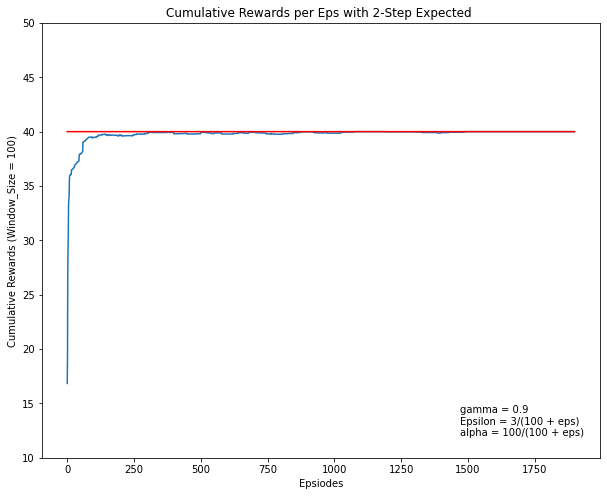

In [271]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_2s_Exp_SARSA[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with 2-Step Expected ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 3/(100 + eps) \nalpha = 100/(100 + eps)", transform=ax.transAxes)
plt.show()

# n-Step Backup Tree 

## n = 1 

In [272]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()
 
num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_1s_Tree = []
n = 1
agent =nStep_tree_backup_Agent('1',env,states,actions,n = 4,epsilon = 0.5,learning_rate = 0.2,gamma = 0.9,dec_eps = [1,100,1],dec_alph=[100,100,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    eps_rewards  = []
    eps_states = []
    eps_actions = []
    env.reset()
    agent.set_current_state(44)
    S0 = agent.get_current_state()
    A0 = agent.choose_action()
    eps_states.append(S0)
    eps_actions.append(A0)
    eps_rewards.append(0)
    T = 100000000000000000
    t = 0 

    while 0 == 0:
        if t < T :
            S_tp1, R_tp1 , done, info = agent.take_action(eps_actions[t])
            eps_states.append(S_tp1)
            eps_rewards.append(R_tp1)
            n_done += int(done)
            if n_done == 2 : 
                T = t + 1 
            else: 
                A_tp1 = agent.choose_action()
                eps_actions.append(A_tp1)
        tau = t + 1 - n 
        if tau >= 0:
            if t + 1 >= T :
                G = eps_rewards [-1]
            else:
                G =  agent.calculate_G_Expected(eps_rewards[t+1],eps_states[t+1])
            k = min(t,T-1)
            for x in range(k,tau,-1):
                G = agent.calculate_G_treebackup(eps_rewards[k],eps_states[k],eps_actions[k],G)
            agent.update_Q(G,eps_states[tau],eps_actions[tau])
        
        if tau == T - 1:
            break 
        t = t + 1
    Rewards.append(sum(eps_rewards))
    if e >= 100 : Win_Rew_1s_Tree.append((sum(eps_rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_1s_Tree.append(sum(eps_rewards))
    print("The number of steps in episode is : {}".format(len(eps_states)-2))
    print("The sum of Rewards is : {} ".format(sum(eps_rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

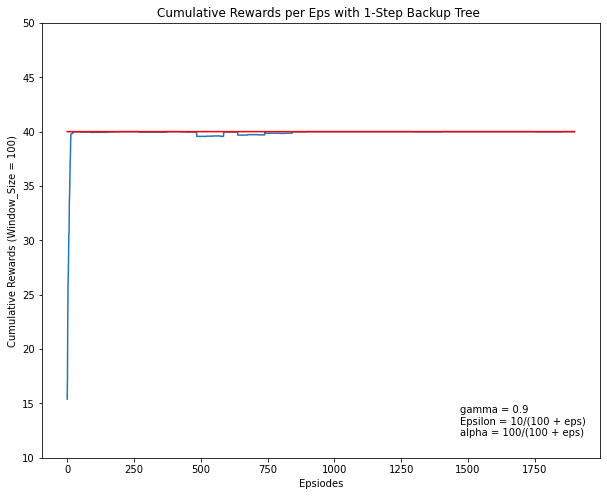

In [273]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_1s_Tree[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with 1-Step Backup Tree ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 10/(100 + eps) \nalpha = 100/(100 + eps)", transform=ax.transAxes)
plt.show()

## n = 2

In [274]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_2s_Tree = []
n = 2
agent =nStep_tree_backup_Agent('1',env,states,actions,n = 2,epsilon = 0.5,learning_rate = 0.2,gamma = 0.9,dec_eps = [3,100,1],dec_alph=[100,100,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    eps_rewards  = []
    eps_states = []
    eps_actions = []
    env.reset()
    agent.set_current_state(44)
    S0 = agent.get_current_state()
    A0 = agent.choose_action()
    eps_states.append(S0)
    eps_actions.append(A0)
    eps_rewards.append(0)
    T = 100000000000000000
    t = 0 

    while 0 == 0:
        if t < T :
            S_tp1, R_tp1 , done, info = agent.take_action(eps_actions[t])
            eps_states.append(S_tp1)
            eps_rewards.append(R_tp1)
            n_done += int(done)
            if n_done == 2 : 
                T = t + 1 
            else: 
                A_tp1 = agent.choose_action()
                eps_actions.append(A_tp1)
        tau = t + 1 - n 
        if tau >= 0:
            if t + 1 >= T :
                G = eps_rewards [-1]
            else:
                G =  agent.calculate_G_Expected(eps_rewards[t+1],eps_states[t+1])
            k = min(t,T-1)
            for x in range(k,tau,-1):
                G = agent.calculate_G_treebackup(eps_rewards[k],eps_states[k],eps_actions[k],G)
            agent.update_Q(G,eps_states[tau],eps_actions[tau])
        
        if tau == T - 1:
            break 
        t = t + 1

    Rewards.append(sum(eps_rewards))
    if e >= 100 : Win_Rew_2s_Tree.append((sum(eps_rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_2s_Tree.append(sum(eps_rewards))
    print("The number of steps in episode is : {}".format(len(eps_states)-2))
    print("The sum of Rewards is : {} ".format(sum(eps_rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

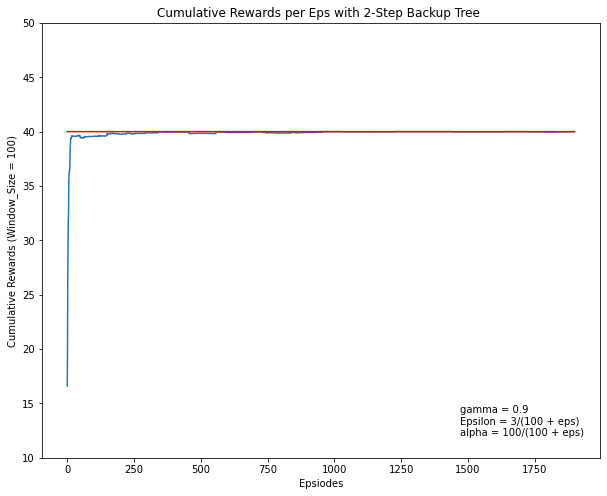

In [275]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_2s_Tree[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with 2-Step Backup Tree ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.9 \nEpsilon = 3/(100 + eps) \nalpha = 100/(100 + eps)", transform=ax.transAxes)
plt.show()

## n = 3

In [276]:
random.seed(2045)
env =  GridworldEnv2()
env.reset()

num_episodes = 2000
states = list(range(100))
actions = [0,1,2,3]
Rewards = []
Win_Rew_3s_Tree = []
n = 3
agent =nStep_tree_backup_Agent('1',env,states,actions,n = 3,epsilon = 0.5,learning_rate = 0.2,gamma = 0.9,dec_eps = [2,100,1],dec_alph=[100,100,1])

for e in range(num_episodes):
    print("-"*25,"This is episode {} ".format(e),"-"*25,"\n")
    n_done = 0
    eps_rewards  = []
    eps_states = []
    eps_actions = []
    env.reset()
    agent.set_current_state(44)
    S0 = agent.get_current_state()
    A0 = agent.choose_action()
    eps_states.append(S0)
    eps_actions.append(A0)
    eps_rewards.append(0)
    T = 100000000000000000
    t = 0 

    while 0 == 0:
        if t < T :
            S_tp1, R_tp1 , done, info = agent.take_action(eps_actions[t])
            eps_states.append(S_tp1)
            eps_rewards.append(R_tp1)
            n_done += int(done)
            if n_done == 2 : 
                T = t + 1 
            else: 
                A_tp1 = agent.choose_action()
                eps_actions.append(A_tp1)
        tau = t + 1 - n 
        if tau >= 0:
            if t + 1 >= T :
                G = eps_rewards [-1]
            else:
                G =  agent.calculate_G_Expected(eps_rewards[t+1],eps_states[t+1])
            k = min(t,T-1)
            for x in range(k,tau,-1):
                G = agent.calculate_G_treebackup(eps_rewards[k],eps_states[k],eps_actions[k],G)
            agent.update_Q(G,eps_states[tau],eps_actions[tau])
        
        if tau == T - 1:
            break 
        t = t + 1


    Rewards.append(sum(eps_rewards))
    if e >= 100 : Win_Rew_3s_Tree.append((sum(eps_rewards)+sum(Rewards[e-100:e]))/101)
    else: Win_Rew_3s_Tree.append(sum(eps_rewards))
    print("The number of steps in episode is : {}".format(len(eps_states)-2))
    print("The sum of Rewards is : {} ".format(sum(eps_rewards)),"\n" )
    agent.decay_epsilon()
    agent.decay_learning_rate()
env.close()

40.0  

------------------------- This is episode 1864  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1865  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1866  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1867  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1868  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1869  ------------------------- 

The number of steps in episode is : 10
The sum of Rewards is : 40.0  

------------------------- This is episode 1870  ------------------------- 

The number of steps in episode is 

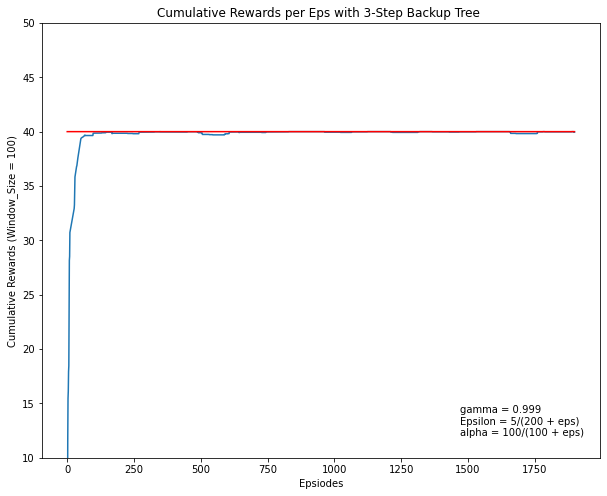

In [277]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_3s_Tree[100:])
ax.plot([40]*1900,'r')
ax.set_ylim((10,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps with 3-Step Backup Tree ")
ax.text(x = 0.75, y = 0.05, s ="gamma = 0.999 \nEpsilon = 5/(200 + eps) \nalpha = 100/(100 + eps)", transform=ax.transAxes)
plt.show()

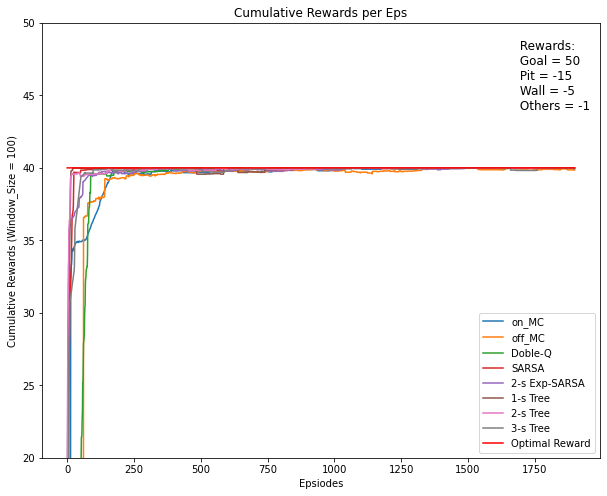

In [298]:
fig, ax = plt.subplots(1,1,figsize = (10,8))
ax.plot(Win_Rew_on_MC[100:])
ax.plot(Win_Rew_off_MC[100:])
ax.plot(Win_Rew_Double_Q[100:])
ax.plot(Win_Rew_SARSA[100:])
ax.plot(Win_Rew_2s_Exp_SARSA[100:])
ax.plot(Win_Rew_1s_Tree[100:])
ax.plot(Win_Rew_2s_Tree[100:])
ax.plot(Win_Rew_3s_Tree[100:])
ax.plot([40]*1900,'r-')
ax.set_ylim((20,50))
ax.set_xlabel("Epsiodes")
ax.set_ylabel("Cumulative Rewards (Window_Size = 100)")
ax.set_title("Cumulative Rewards per Eps")
ax.legend(labels = ["on_MC","off_MC","Doble-Q","SARSA","2-s Exp-SARSA","1-s Tree","2-s Tree","3-s Tree","Optimal Reward"],loc = "lower right")
ax.text(x = 0.85, y = 0.80, s =" Rewards:\n Goal = 50\n Pit = -15\n Wall = -5\n Others = -1",fontsize=12, transform=ax.transAxes)
plt.show()